# SH 2st Catboost(cobe base by JxxHxxx)
## public : 1.0555988997 / private : 1.0311943089 / K-FOLD log_loss mean : 0.7670367796165645

1st catboost보다 log_loss 0.04증가 하지만 Dacon 제출 점수 0.03 상승

## 전처리

1. family_size single, couple, fam, bigfam으로 구분
2. faimily type single, couple로 구분 
3. imcome_type 학생인 경우 working으로 편입
4. income_total에 age_total를 나눈 age_income, 
 income_total에 work_total을 나눈 work_year_income 파생변수 생성
5. income_total, work_year_income, age_income을 바탕으로 occyp_type 클러스터링 실행 후 대치 
6. 모든 numeric 변수 MinMaxScaler 실시 
7. object Oridanry encoder 실시 
8. get dummies 화

카테고리화 하여 점수가 째끔 상승한 것 같은데 큰 효과 없음 
age, begin_month도 카테고리화 할 예정


## 필요한 라이브러리 호출

In [505]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
from sklearn.preprocessing import OrdinalEncoder


warnings.filterwarnings('ignore')

## 데이터 전처리 과정

In [59]:
# 경로 설정 (dataset을 저장하는 경로임.)
path = 'C:/Users/user/Desktop/code/[유비온]신용카드 사용자 연제 예측/'

train = pd.read_csv('{}train.csv'.format(path))
test = pd.read_csv('{}test.csv'.format(path))
train1 = pd.read_csv('{}train.csv'.format(path))
test1 = pd.read_csv('{}test.csv'.format(path))
submission = pd.read_csv('{}sample_submission.csv'.format(path))

In [60]:
train_new = pd.read_csv('{}train.csv'.format(path))

In [61]:
# #쓸모없는 칼럼 삭제
# for df in (train,test):
#     df.drop(['FLAG_MOBIL'], axis=1, inplace=True)   
#     df.drop(columns=['index'], inplace=True)
    
# del df

### 1. 나이, 고용일자를 이용하여 파생변수 형성

In [62]:
# 1st

def year_month_total(df_1, df_2, column, column_name):
    """[나이, 고용연수 파생변수를 생성하기 위한 함수입니다.]

    Args:
        df_1 ([DataFrame]): [데이터 프레임 이름을 입력해주세요]
        df_2 ([DataFrame]): [데이터 프레임 이름을 입력해주세요]
        column ([생성할 컬럼의 기준 컬럼 명]): [생성할 컬럼의 기준 컬럼 명을 입력해주세요]
        column_name ([생성할 컬럼의 이름]): [연단위, 연+월단위로 표시된 파생변수 이름입니다.]
    """
    # 변수 설정
    
    df_list = []
    df_list.append(df_1)
    df_list.append(df_2)
    names = ['train', 'test']
    
    # 입력한 컬럼이 DAYS_BIRTH인 경우 If로 처리
    
    if (column == 'DAYS_BIRTH') == True:    
        for dataset,name in zip(df_list,names):
            dataset['DAYS_BIRTH_MOD'] = dataset[column]-dataset['begin_month']*30
            dataset['{}_year'.format(column_name)] = dataset['DAYS_BIRTH_MOD'].abs()//365
            dataset['{}_month'.format(column_name)] = (dataset['DAYS_BIRTH_MOD'].abs()%365)//30
            dataset['{}_total'.format(column_name)] = dataset['{}_year'.format(column_name)] + round(dataset['{}_month'.format(column_name)] * (1/12), 2)
            # dataset.drop(columns=['{}_month'.format(column_name)], inplace=True)
            dataset['{}_month'.format(column_name)] = dataset['DAYS_BIRTH_MOD'].abs()//30
        
            print('{0}set에 {1}_year, {1}_month, {1}_total, {2} 컬럼을 생성하였습니다. \n'.format(name,column_name,'DAYS_BIRTH_MOD'))
    
    # 입력한 컬럼이 DAYS_EMPLOYED인 경우 else로 처리 (occyp_type 처리를 위한 작업이므로 1번째로 수행)
    
    else:
        for dataset,name in zip(df_list,names):
            dataset['DAYS_EMPLOYED_MOD'] = dataset['DAYS_EMPLOYED']-dataset['begin_month']*30
            print('{}set에 근무일자가 잘못기입된 '.format(name) +
                  '\033[96m' + '{} cases'.format(len(dataset[dataset['DAYS_EMPLOYED_MOD']>=0])) + 
                  '\033[0m' + '에 대한 처리를 시작합니다.')
            # Begin_month 처리한 사람들 대상 (카드를 생성한 시점에 무직일 확률이 높은 사람들 + 애초에 무직)
            dataset.loc[(dataset['DAYS_EMPLOYED_MOD']>0), 'DAYS_EMPLOYED_MOD'] = 0
            a = len(dataset.loc[(dataset['DAYS_EMPLOYED_MOD']==0)])
            # Emplyed 시간이 애초에 없는 사람 대상 (애초에 무직)
            dataset['DAYS_EMPLOYED'] = dataset['DAYS_EMPLOYED'].replace(365243, 0)
            b = len(dataset.loc[(dataset['DAYS_EMPLOYED']==0)])
            print('\033[92m'+'원래 무직인 사람들의 수 : {}'.format(b))
            print('카드를 생성한 시점에 무직일 확률일 높은 사람들 : {}'.format(a-b) + '\033[0m')
            dataset['{}_year'.format(column_name)] = dataset['DAYS_EMPLOYED_MOD'].abs()//365
            dataset['{}_month'.format(column_name)] = (dataset['DAYS_EMPLOYED_MOD'].abs()%365)//30
            dataset['{}_total'.format(column_name)] = dataset['{}_year'.format(column_name)] + round(dataset['{}_month'.format(column_name)] * (1/12), 2)
            # dataset.drop(columns=['{}_month'.format(column_name)], inplace=True)
            dataset['{}_month'.format(column_name)] = dataset['DAYS_EMPLOYED_MOD'].abs()//30
        
            print('{0}set에 {1}_year, {1}_month, {1}_total, {2} 컬럼을 생성하였습니다. \n'.format(name,column_name,'DAYS_BIRTH_MOD'))

        
    del df_list,names
    return dataset.head(1)

In [63]:
year_month_total(train, test,'DAYS_BIRTH','age')

trainset에 age_year, age_month, age_total, DAYS_BIRTH_MOD 컬럼을 생성하였습니다. 

testset에 age_year, age_month, age_total, DAYS_BIRTH_MOD 컬럼을 생성하였습니다. 



,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,work_phone,phone,email,occyp_type,family_size,begin_month,DAYS_BIRTH_MOD,age_year,age_month,age_total
0,26457,M,Y,N,0,112500.00,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,...,0,1,0,NaN,2.00,-60.00,-20190.00,55.00,673.00,55.25


In [64]:
year_month_total(train, test,'DAYS_EMPLOYED','work')

trainset에 근무일자가 잘못기입된 8357 cases에 대한 처리를 시작합니다.
원래 무직인 사람들의 수 : 4438
카드를 생성한 시점에 무직일 확률일 높은 사람들 : 3919
trainset에 work_year, work_month, work_total, DAYS_BIRTH_MOD 컬럼을 생성하였습니다. 

testset에 근무일자가 잘못기입된 3169 cases에 대한 처리를 시작합니다.
원래 무직인 사람들의 수 : 1697
카드를 생성한 시점에 무직일 확률일 높은 사람들 : 1472
testset에 work_year, work_month, work_total, DAYS_BIRTH_MOD 컬럼을 생성하였습니다. 



,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,family_size,begin_month,DAYS_BIRTH_MOD,age_year,age_month,age_total,DAYS_EMPLOYED_MOD,work_year,work_month,work_total
0,26457,M,Y,N,0,112500.00,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,...,2.00,-60.00,-20190.00,55.00,673.00,55.25,0.00,0.00,0.00,0.00


### 2. 직업 Nan 값 처리

In [65]:
# 2nd

def occyp_type_nan(df_1, df_2):
    """[직업 컬럼 내의 Nan 값을 처리합니다.]

    Args:
        df_1 ([DataFrame]): [데이터 프레임 이름을 입력해주세요]
        df_2 ([DataFrame]): [데이터 프레임 이름을 입력해주세요]
    """
    # 변수 설정
    
    df_list = []
    df_list.append(df_1)
    df_list.append(df_2)
    names = ['train', 'test']

    # 무직자 처리 함수
    
    for dataset,name in zip(df_list,names):
        dataset['occyp_type'] = dataset['occyp_type'].fillna('Nan')
        
        print('직업 컬럼의 ' +
              '\033[92m' + 'Nan value {}명 중 '.format(len(dataset.loc[dataset['occyp_type'] == 'Nan'])) +
              '\033[96m' + '{}명이 실제 고용일수가 0일입니다. '.format(len(dataset.loc[(dataset['occyp_type'] == 'Nan') & (dataset['DAYS_EMPLOYED'] == 0)])) + 
              '\033[0m'+ '따라서 jobless로 처리합니다.')
        
        dataset.loc[(dataset['occyp_type'] == 'Nan') & (dataset['DAYS_EMPLOYED'] == 0), 'occyp_type'] = 'retired'
        
        # 무직자는 아니지만 데이터가 없는 경우
        
        print('나머지 {}명 데이터는 no_data로 처리합니다.'.format(len(dataset.loc[dataset['occyp_type'] == 'Nan'])))
        
        dataset.loc[dataset['occyp_type'] == 'Nan', 'occyp_type'] = 'no data'
        
        print('{}set의 직업 Nan value를 처리하였습니다.\n'.format(name))
        
    del df_list, names
    return dataset.head(1)

occyp_type_nan(train, test)

직업 컬럼의 Nan value 8171명 중 4438명이 실제 고용일수가 0일입니다. 따라서 jobless로 처리합니다.
나머지 3733명 데이터는 no_data로 처리합니다.
trainset의 직업 Nan value를 처리하였습니다.

직업 컬럼의 Nan value 3152명 중 1697명이 실제 고용일수가 0일입니다. 따라서 jobless로 처리합니다.
나머지 1455명 데이터는 no_data로 처리합니다.
testset의 직업 Nan value를 처리하였습니다.



,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,family_size,begin_month,DAYS_BIRTH_MOD,age_year,age_month,age_total,DAYS_EMPLOYED_MOD,work_year,work_month,work_total
0,26457,M,Y,N,0,112500.00,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,...,2.00,-60.00,-20190.00,55.00,673.00,55.25,0.00,0.00,0.00,0.00


### 3. ID컬럼 생성

In [66]:
def ID_col(df_1, df_2):
    """[데이터 셋 전처리 함수입니다.]

    Args:
        df_1 ([Dataset]): [train 데이터셋을 입력해주세요]
        df_2 ([Dataset]): [test 데이터셋을 입력해주세요]
    """
    
    # 변수 설정
     
    df_list = []
    df_list.append(df_1)
    df_list.append(df_2)
    a = []
    change_credit = 0
    names = ['train', 'test']
    
    # ID 생성
    
    for name, dataset, in zip(names, df_list):
    #for dataset in df_list:
        dataset['ID'] = dataset['gender'].astype(str) +'.'+ dataset['car'].astype(str)+'.' + dataset['reality'].astype(str)+'.' + \
                dataset['child_num'].astype(str)+'.' + dataset['income_total'].astype(str) +'.'+ dataset['income_type'].astype(str) +'.'+ \
                dataset['edu_type'].astype(str)+'.' + dataset['family_type'].astype(str)+'.' + dataset['house_type'].astype(str) +'.'+ \
                dataset['DAYS_BIRTH'].astype(str) +'.'+ dataset['DAYS_EMPLOYED'].astype(str) +'.'+ dataset['work_phone'].astype(str) +'.'+ \
                dataset['phone'].astype(str) +'.'+ dataset['email'].astype(str) +'.' + dataset['family_size'].astype(str)+'.' + dataset['occyp_type'].astype(str)
        
        dataset = dataset.sort_values(['ID','begin_month'], ascending=[True, False])
        dataset.reset_index(inplace=True)
        dataset.drop(columns={'index'}, inplace=True)

        # OrdinalEncoder로 ID 변환
        
        print('\033[96m' + '해당 Data 내의 고유 ID 수는 {}입니다. '.format(dataset['ID'].nunique()) + 
              '\033[0m' + 'OrdinalEncoder를 이용힌 변환을 시작합니다.')
        encode = OrdinalEncoder()
        dataset[['ID']] = encode.fit_transform(dataset[['ID']])

        # Nth_card 컬럼 추가 (ID가 같은데 카드 개수가 여러 개인 사람을 대상으로 몇 번째 카드를 만들었는지 생성해준다)
        
        print('Column(Nth_card)을 생성합니다.')
        for i in tqdm(range(dataset['ID'].nunique())):
            Nth_card = len(dataset[dataset['ID']==i]) + 1
            
            while Nth_card > 0:
                Nth_card = Nth_card -1
                a.append(Nth_card)
                if Nth_card == 1:
                    break
                
        dataset['Nth_card'] = a        
        a.clear()
        print('\033[92m' + '신규로 카드를 개설한 사람의 수 : {}'.format(dataset[dataset['begin_month']==0.0]['ID'].nunique()) +
              '\033[0m')
        
        # Credit이 좋아지지 않고 악화된 경우를 체크하는 부분 (begin_month기준으로 Nth_card를 추가해줬으므로 인덱스 값을 기준으로 시행한다.)
        
        if (dataset['ID'].nunique() > 8000)==True:
            print('credit 정보를 확인하고 시간이 지나며 credit이 악화된 사례가 있는지 확인합니다.')
            for i in tqdm(range(dataset['ID'].nunique())):
                num = dataset.loc[dataset['ID'] == i]['credit'].to_list()
                for j in range(len(num)-1):
                    if (num[j] <= num[j+1]) == True:
                        pass
                    else :
                        change_credit += 1
                        break
            print('\033[96m'+'{}명 (전체 인원 중 {:.2f}%)은 credit이 개선되지 않고 악화된 사례가 존재합니다.'.format(change_credit, 
                                                                        (change_credit/dataset['ID'].nunique())*100) + 
                  '\033[0m')  
        else:
            print('\033[96m' + 'credit 정보가 없는 testset입니다.' + 
                  '\033[0m')
        
        # dataset 저장부분
        
        print('dataset(user_list_{})을 저장합니다. \n'.format(name))    
        dataset.to_csv('{}user_list_{}.csv'.format(path, name))
        
    
    del names, a
    return dataset.head(5)

In [67]:
ID_col(train, test)

해당 Data 내의 고유 ID 수는 8759입니다. OrdinalEncoder를 이용힌 변환을 시작합니다.
Column(Nth_card)을 생성합니다.


100%|██████████| 8759/8759 [00:01<00:00, 5101.73it/s]


신규로 카드를 개설한 사람의 수 : 214
credit 정보를 확인하고 시간이 지나며 credit이 악화된 사례가 있는지 확인합니다.


100%|██████████| 8759/8759 [00:02<00:00, 3989.42it/s]


1842명 (전체 인원 중 21.03%)은 credit이 개선되지 않고 악화된 사례가 존재합니다.
dataset(user_list_train)을 저장합니다. 

해당 Data 내의 고유 ID 수는 5585입니다. OrdinalEncoder를 이용힌 변환을 시작합니다.
Column(Nth_card)을 생성합니다.


100%|██████████| 5585/5585 [00:01<00:00, 5464.60it/s]


신규로 카드를 개설한 사람의 수 : 82
credit 정보가 없는 testset입니다.
dataset(user_list_test)을 저장합니다. 



,level_0,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,DAYS_BIRTH_MOD,age_year,age_month,age_total,DAYS_EMPLOYED_MOD,work_year,work_month,work_total,ID,Nth_card
0,6462,F,N,N,0,103500.00,Pensioner,Higher education,Married,House / apartment,...,-21611.00,59.00,720.00,59.17,0.00,0.00,0.00,0.00,0.00,3
1,4122,F,N,N,0,103500.00,Pensioner,Higher education,Married,House / apartment,...,-20321.00,55.00,677.00,55.67,0.00,0.00,0.00,0.00,0.00,2
2,3936,F,N,N,0,103500.00,Pensioner,Higher education,Married,House / apartment,...,-20111.00,55.00,670.00,55.08,0.00,0.00,0.00,0.00,0.00,1
3,137,F,N,N,0,103500.00,Pensioner,Higher education,Single / not married,House / apartment,...,-23703.00,64.00,790.00,64.92,0.00,0.00,0.00,0.00,1.00,1
4,2434,F,N,N,0,103500.00,Pensioner,Secondary / secondary special,Married,House / apartment,...,-19793.00,54.00,659.00,54.17,0.00,0.00,0.00,0.00,2.00,2


In [68]:
train = pd.read_csv('{}user_list_train.csv'.format(path))
test = pd.read_csv('{}user_list_test.csv'.format(path))

### faimly_size 조정

In [69]:
def replace_value_family(df_1, df_2, num_of_outlier):
    """[Family_size의 outlier를 대치해주는 작업을 시행합니다.]

    Args:
        df_1 ([DataFrame]): [데이터 프레임 이름을 입력해주세요]
        df_2 ([DataFrame]): [데이터 프레임 이름을 입력해주세요]
        num_of_outlier ([outlier_standard]): [family_size의 outlier 기준을 입력하세요]
    """
    # 변수 설정
    
    df_list = []
    df_list.append(df_1)
    df_list.append(df_2)
    names = ['train', 'test']

    # family_size Outlier를 처리하는 작업
    
    for dataset,name in zip(df_list,names):
        
        print('family_size와 child_num의 다중공선성 문제로 child_num 컬럼을 삭제해줍니다.')
        
        dataset.drop(columns=['child_num'], inplace=True)
        
        print('\033[96m' + 'family_size {}명 이상인 사람의 수 : {}'.format(num_of_outlier, 
                                                                      len(dataset.loc[dataset['family_size'] >= num_of_outlier])) +
              '\033[0m')
        
        sub = dataset.loc[dataset['family_size']>= num_of_outlier]
        
        for i in tqdm(range(len(sub))):
        
            a = int(dataset[dataset['family_type'] == sub['family_type'].values[i]].mean()['family_size'])
            
            dataset.loc[(dataset['family_size']>= num_of_outlier), 'family_size'] = a
        
        # 잘 처리되었는지 확인하는 부분
        
        print('\033[96m' + 'family_size {}명 이상인 사람의 수 : {}'.format(num_of_outlier, 
                                                        len(dataset.loc[dataset['family_size'] >= num_of_outlier]))+
              '\033[0m')

        # family_size를 조정하고 난 후에 1인당 소득으로 total_income을 scale_down 해줌.
        
        print('1인당 소득으로 소득 수준을 조정합니다.')
        
        dataset['income_mean'] = dataset['income_total'] / dataset['family_size']
        
        print('{} 데이터 셋 처리 완료.\n'.format(name))
    
    del sub,df_list, names
    return dataset.head(1)

replace_value_family(train, test, 7)

family_size와 child_num의 다중공선성 문제로 child_num 컬럼을 삭제해줍니다.
family_size 7명 이상인 사람의 수 : 15


100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


family_size 7명 이상인 사람의 수 : 0
1인당 소득으로 소득 수준을 조정합니다.
train 데이터 셋 처리 완료.

family_size와 child_num의 다중공선성 문제로 child_num 컬럼을 삭제해줍니다.
family_size 7명 이상인 사람의 수 : 10


100%|██████████| 10/10 [00:00<00:00, 16.01it/s]

family_size 7명 이상인 사람의 수 : 0
1인당 소득으로 소득 수준을 조정합니다.
test 데이터 셋 처리 완료.



,Unnamed: 0,level_0,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,...,age_year,age_month,age_total,DAYS_EMPLOYED_MOD,work_year,work_month,work_total,ID,Nth_card,income_mean
0,0,6462,F,N,N,103500.00,Pensioner,Higher education,Married,House / apartment,...,59.00,720.00,59.17,0.00,0.00,0.00,0.00,0.00,3,51750.00


In [70]:
names = ['train', 'test']

for name,dataset in zip(names, [train, test]):
    dataset.drop(columns=['DAYS_BIRTH','DAYS_EMPLOYED'], inplace=True)
    dataset.to_csv('{}final_set_{}.csv'.format(path,name))

In [71]:
#추가변수 생성 contact num
train['contact_num'] = train['FLAG_MOBIL'] + train['work_phone'] + train['phone'] + train['email']
test['contact_num'] = test['FLAG_MOBIL'] + test['work_phone'] + test['phone'] + test['email']
test.drop(columns=['FLAG_MOBIL', 'work_phone', 'phone', 'email' ], inplace=True)
train.drop(columns=['FLAG_MOBIL', 'work_phone', 'phone', 'email' ], inplace=True)

In [ ]:
test.drop(columns=['Unnamed: 0','level_0'], inplace=True)
train.drop(columns=['Unnamed: 0','level_0'], inplace=True)

In [ ]:
#train.to_csv('train_1103.csv')
#test.to_csv('test_1103.csv')

# 할것
### 1. 스케일링 (log, minmax, /standard/)
### 2. 파생변수 생성
- income/work_year 별 5분위
### 3. 인코딩(ordinary)

In [76]:
#새로불러올때 이거불러오면 됨
train = pd.read_csv(r'C:\Users\user\Desktop\code\[유비온]신용카드 사용자 연제 예측\SH\train_1103.csv', index_col='Unnamed: 0')
test = pd.read_csv(r'C:\Users\user\Desktop\code\[유비온]신용카드 사용자 연제 예측\SH\test_1103.csv', index_col='Unnamed: 0')
#데이터 DAYS_EMPLOYED 드랍상태라 다시 가져와줌
train['DAYS_EMPLOYED'] = train1['DAYS_EMPLOYED']
test['DAYS_EMPLOYED'] = test1['DAYS_EMPLOYED']

In [402]:
#test.drop(columns=['work_year_income','age_income'], inplace=True)
#train.drop(columns=['work_year_income','age_income'], inplace=True)

In [82]:
train.head(1)

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,occyp_type,family_size,...,age_total,DAYS_EMPLOYED_MOD,work_year,work_month,work_total,ID,Nth_card,income_mean,contact_num,DAYS_EMPLOYED
0,F,N,N,103500.00,Pensioner,Higher education,Married,House / apartment,retired,2.00,...,57.42,0.00,0.00,0.00,0.00,0.00,3,51750.00,2,-4709


In [21]:
train.columns

Index(['gender', 'car', 'reality', 'income_total', 'income_type', 'edu_type',
       'family_type', 'house_type', 'occyp_type', 'family_size', 'begin_month',
       'credit', 'DAYS_BIRTH_MOD', 'age_year', 'age_month', 'age_total',
       'DAYS_EMPLOYED_MOD', 'work_year', 'work_month', 'work_total', 'ID',
       'Nth_card', 'income_mean', 'contact_num', 'DAYS_EMPLOYED'],
      dtype='object')

In [ ]:
#일한경험이 있고 소득타입이 pensioner인데 직업이 있음 -> 은퇴로 감안하여 retired 처리 (할려고하다가 몇명 안되서 걍 무시 8명 정도)
#print(train[(train['income_type']=='Pensioner') & (train['DAYS_EMPLOYED']!=365243) & (train['occyp_type']!='retired')]['occyp_type'].value_counts())
#train.loc[((train['income_type']=='Pensioner') & (train['DAYS_EMPLOYED']!=365243) & (train['occyp_type']!='retired')), 'occyp_type'] = 'retired'
#print(test[(test['income_type']=='Pensioner') & (test['DAYS_EMPLOYED']!=365243) & (test['occyp_type']!='retired')]['occyp_type'].value_counts())
#test.loc[((test['income_type']=='Pensioner') & (test['DAYS_EMPLOYED']!=365243) & (test['occyp_type']!='retired')), 'occyp_type'] = 'retired'

In [99]:
q=train[(train['income_type']=='Pensioner')]['income_total'].value_counts().sort_values()

In [88]:
train[(train['income_type']=='Pensioner') & (train['DAYS_EMPLOYED']!=365243) & (train['occyp_type']!='retired')].sort_values('income_total')
#print(train[(train['income_type']=='Pensioner') & (train['DAYS_EMPLOYED']!=365243) & (train['occyp_type']!='retired')]['occyp_type'].value_counts())

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,occyp_type,family_size,...,age_total,DAYS_EMPLOYED_MOD,work_year,work_month,work_total,ID,Nth_card,income_mean,contact_num,DAYS_EMPLOYED
14693,F,Y,Y,112500.00,Pensioner,Secondary / secondary special,Married,House / apartment,no data,2.00,...,54.08,-73.00,0.00,2.00,0.17,4777.00,1,56250.00,2,-706
6311,F,N,Y,157500.00,Pensioner,Higher education,Married,House / apartment,Medicine staff,2.00,...,31.25,-365.00,1.00,12.00,1.00,2065.00,1,78750.00,3,-2193
25260,M,Y,Y,157500.00,Pensioner,Secondary / secondary special,Married,House / apartment,Drivers,3.00,...,28.67,0.00,0.00,0.00,0.00,8385.00,1,52500.00,2,-110
1364,F,N,N,180000.00,Pensioner,Secondary / secondary special,Civil marriage,Municipal apartment,Laborers,2.00,...,54.75,0.00,0.00,0.00,0.00,472.00,1,90000.00,1,-3350
12880,F,N,Y,270000.00,Pensioner,Higher education,Single / not married,House / apartment,Core staff,3.00,...,25.58,-1665.00,4.00,55.00,4.50,4221.00,1,90000.00,1,-2757
15960,F,Y,Y,270000.00,Pensioner,Higher education,Married,House / apartment,Accountants,2.00,...,46.75,0.00,0.00,0.00,0.00,5181.00,1,135000.00,2,-109
13126,F,N,Y,292500.00,Pensioner,Secondary / secondary special,Married,House / apartment,Core staff,5.00,...,32.08,-42.00,0.00,1.00,0.08,4318.00,1,58500.00,1,-2207
13907,F,Y,N,315000.00,Pensioner,Higher education,Married,House / apartment,no data,2.00,...,34.17,0.00,0.00,0.00,0.00,4550.00,1,157500.00,3,-3255
14017,F,Y,N,450000.00,Pensioner,Higher education,Married,House / apartment,Managers,2.00,...,50.42,-4141.00,11.00,138.00,11.33,4582.00,1,225000.00,3,-203


In [100]:
#추가 변수 생성 work_year_income = income/work_year 
a=train['income_total']/train['work_total']
train['work_year_income'] = round(a,2)
b=test['income_total']/test['work_total']
test['work_year_income']=round(b,2)

In [101]:
#work_year 0인 경우 work_year_income 0처리해줌 클러스터링할때 따로 처리해줄 예정
train.loc[train['work_total']==0, 'work_year_income'] = 0
test.loc[test['work_total']==0, 'work_year_income'] = 0

In [102]:
#추가 변수 생성 work_age_income = income/age
c = train['income_total']/train['age_total']
train['age_income'] = round(c,2)
d = test['income_total']/test['age_total']
test['age_income'] = round(d,2)


In [34]:
train.head(1)

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,occyp_type,family_size,...,work_year,work_month,work_total,ID,Nth_card,income_mean,contact_num,DAYS_EMPLOYED,work_year_income,age_income
0,F,N,N,103500.0,Pensioner,Higher education,Married,House / apartment,retired,2.0,...,0.0,0.0,0.0,0.0,3,51750.0,2,-4709,0.0,1802.51


In [356]:
pd.options.display.float_format = '{:.2f}'.format
e = train[train['work_year_income']>0].groupby(train['occyp_type']).mean().sort_values('work_year_income')
e= e[['income_total', 'work_total','work_year_income', 'age_total','age_income']]
f= e[['income_total','work_year_income', 'age_income']]
#f1= e[['income_total','work_year_income', 'age_income']]
#f2= e[['income_total','work_year_income', 'age_income']]

In [314]:
f

,income_total,work_year_income,age_income
occyp_type,,,
Secretaries,167810.13,50271.28,4222.43
Medicine staff,168039.50,56163.41,4236.80
Realty agents,247425.00,63974.43,6678.19
Low-skill Laborers,140310.00,87214.90,3768.45
Cooking staff,146251.27,90385.85,3913.94
HR staff,183681.82,92505.78,5293.01
Laborers,181080.25,98445.67,5039.56
Accountants,205898.90,99048.59,5500.89
Cleaning staff,147468.46,99388.16,3250.73


# 직업 클러스트 구분 (4개 채택)

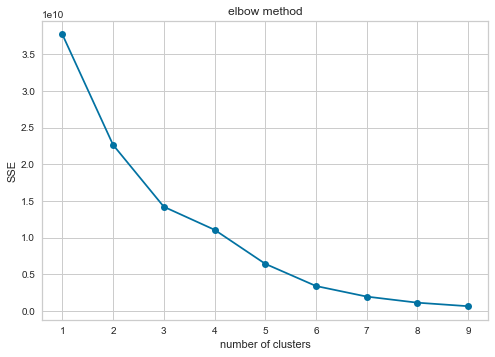

In [271]:
import matplotlib.pyplot as plt
def elbow(data, length):
    sse = [] # sum of squre error 오차제곱합
    for i in range(1, length):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(data)
        # SSE 값 저장
        sse.append(kmeans.inertia_)
    plt.plot(range(1, length), sse, 'bo-')
    plt.title("elbow method")
    plt.xlabel("number of clusters")
    plt.ylabel("SSE")
    plt.show()
elbow(f, 10)

In [323]:
from sklearn.metrics import silhouette_score, silhouette_samples
import seaborn as sns
def visualize_silhouette_layer(data, param_init='random', param_n_init=10, param_max_iter=300):
    clusters_range = range(2,10)
    results = []

    for i in clusters_range:
        clusterer = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.show()

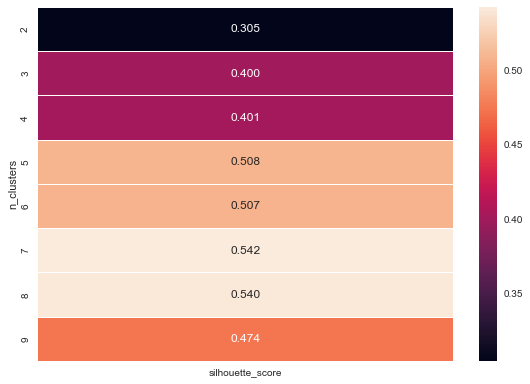

In [324]:
visualize_silhouette_layer(f)

## 밑에 스케일링 하다가 때려치고 걍 non scaler로 함 
non , minmax 둘다 클러스트링한 결과 육안으로는 차이 그렇게 크게 나지않는 것 같음 

시각화 실패

In [369]:
kmeans = KMeans(n_clusters= 4)
kmeans.fit(f)

kmeans.labels_

array([0, 0, 1, 0, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 2, 2, 2])

In [370]:
f2['non'] = kmeans.labels_
f2

,income_total,work_year_income,age_income,non,minmax
occyp_type,,,,,
Secretaries,167810.13,50271.28,4222.43,0,0
Medicine staff,168039.50,56163.41,4236.80,0,0
Realty agents,247425.00,63974.43,6678.19,1,3
Low-skill Laborers,140310.00,87214.90,3768.45,0,0
Cooking staff,146251.27,90385.85,3913.94,0,0
HR staff,183681.82,92505.78,5293.01,3,2
Laborers,181080.25,98445.67,5039.56,3,2
Accountants,205898.90,99048.59,5500.89,3,2
Cleaning staff,147468.46,99388.16,3250.73,0,0


## MinMaxScaler

In [359]:
#작업 전 minmaxscaler 처리
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler = MinMaxScaler()
MinMaxScaler.fit(f)
f_minmax = MinMaxScaler.transform(f)

In [360]:
MinMaxScaler.fit(f)

MinMaxScaler()

In [361]:
f_minmax

array([[0.19689265, 0.        , 0.23519635],
       [0.19853492, 0.04922853, 0.23867484],
       [0.76691123, 0.11448943, 0.82960354],
       [0.        , 0.30866279, 0.12531327],
       [0.04253772, 0.33515601, 0.16052845],
       [0.31052919, 0.35286794, 0.49432522],
       [0.29190277, 0.40249555, 0.43297957],
       [0.46959681, 0.40753297, 0.5446418 ],
       [0.05125243, 0.41037006, 0.        ],
       [0.36401433, 0.43583529, 0.47817979],
       [0.37012113, 0.45941191, 0.5229121 ],
       [0.42121795, 0.46487769, 0.51548086],
       [0.45716516, 0.4804145 , 0.47656582],
       [0.12071057, 0.59547685, 0.3626833 ],
       [0.25086603, 0.64110103, 0.42572029],
       [1.        , 0.66948547, 1.        ],
       [0.51075173, 0.71754692, 0.58195279],
       [0.48947904, 0.82116114, 0.84535691],
       [0.34283811, 1.        , 0.29840349]])

In [371]:
kmeans = KMeans(n_clusters= 4)
kmeans.fit(f_minmax)

kmeans.labels_

array([2, 2, 0, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1])

In [372]:
f2['minmax'] = kmeans.labels_
f2

,income_total,work_year_income,age_income,non,minmax
occyp_type,,,,,
Secretaries,167810.13,50271.28,4222.43,0,2
Medicine staff,168039.50,56163.41,4236.80,0,2
Realty agents,247425.00,63974.43,6678.19,1,0
Low-skill Laborers,140310.00,87214.90,3768.45,0,2
Cooking staff,146251.27,90385.85,3913.94,0,2
HR staff,183681.82,92505.78,5293.01,3,1
Laborers,181080.25,98445.67,5039.56,3,1
Accountants,205898.90,99048.59,5500.89,3,1
Cleaning staff,147468.46,99388.16,3250.73,0,2


## RobustScaler

In [331]:
# from sklearn.preprocessing import RobustScaler
# robust = RobustScaler()

# f_robust = robust.fit_transform(f)
# f_robust

array([[-0.54935446, -1.58903353, -0.91001165],
       [-0.54317275, -1.40954877, -0.89689702],
       [ 1.59625695, -1.17161084,  1.33102346],
       [-1.29047962, -0.46366454, -1.32429303],
       [-1.13036306, -0.36707159, -1.19152471],
       [-0.12161425, -0.30249476,  0.06695651],
       [-0.19172612, -0.12155501, -0.16432895],
       [ 0.47713343, -0.10318884,  0.25666019],
       [-1.09755993, -0.09284496, -1.79674936],
       [ 0.07970958,  0.        ,  0.00608497],
       [ 0.10269624,  0.08595916,  0.17473484],
       [ 0.29503019,  0.10588713,  0.14671754],
       [ 0.43033936,  0.16253355,  0.        ],
       [-0.83611203,  0.5820451 , -0.42936009],
       [-0.34619284,  0.74838854, -0.19169793],
       [ 2.47362823,  0.8518768 ,  1.97345252],
       [ 0.63204499,  1.02710641,  0.39733016],
       [ 0.55197227,  1.40487864,  1.39041686],
       [ 0.        ,  2.05691613, -0.67170795]])

In [316]:
# kmeans = KMeans(n_clusters= 7)
# kmeans.fit(f_robust)

# kmeans.labels_

array([4, 4, 6, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 0, 0, 2, 5, 5, 0])

In [317]:
# f1['robust'] = kmeans.labels_
# f1

,income_total,work_year_income,age_income,minmax,robust,standard
occyp_type,,,,,,
Secretaries,167810.13,50271.28,4222.43,1,4,1
Medicine staff,168039.50,56163.41,4236.80,1,4,1
Realty agents,247425.00,63974.43,6678.19,3,6,6
Low-skill Laborers,140310.00,87214.90,3768.45,5,1,4
Cooking staff,146251.27,90385.85,3913.94,5,1,4
HR staff,183681.82,92505.78,5293.01,2,3,0
Laborers,181080.25,98445.67,5039.56,2,3,0
Accountants,205898.90,99048.59,5500.89,2,3,0
Cleaning staff,147468.46,99388.16,3250.73,5,1,4


## Standard Scaler

In [286]:
# from sklearn.preprocessing import StandardScaler
# standardScaler = StandardScaler()
# f_standard = standardScaler.fit_transform(f)
# f_standard

array([[-0.63948773, -1.86015776, -0.87467114],
       [-0.63264091, -1.65938912, -0.86057084],
       [ 1.73697719, -1.39323573,  1.53479636],
       [-1.46035302, -0.60133886, -1.3200892 ],
       [-1.28300899, -0.49329162, -1.17734224],
       [-0.16572552, -0.42105705,  0.17572429],
       [-0.24338096, -0.21866087, -0.0729442 ],
       [ 0.49744343, -0.19811678,  0.37968577],
       [-1.24667645, -0.1865463 , -1.82805454],
       [ 0.05725942, -0.08269148,  0.11027774],
       [ 0.08271929,  0.013461  ,  0.29160305],
       [ 0.29574709,  0.03575209,  0.26148002],
       [ 0.44561463,  0.09911583,  0.10373544],
       [-0.9570985 ,  0.56837442, -0.35789462],
       [-0.41446727,  0.7544434 , -0.10237018],
       [ 2.70874779,  0.87020363,  2.22550929],
       [ 0.66902244,  1.06621254,  0.53092826],
       [ 0.58033443,  1.48878223,  1.59865367],
       [-0.03102638,  2.21814044, -0.61845694]])

In [287]:
# kmeans = KMeans(n_clusters= 7)
# kmeans.fit(f_standard)

# kmeans.labels_

array([1, 1, 6, 4, 4, 0, 0, 0, 4, 0, 0, 0, 0, 3, 3, 2, 5, 5, 3])

In [288]:
# f1['standard'] = kmeans.labels_
# f1

,income_total,work_year_income,age_income,minmax,robust,standard
occyp_type,,,,,,
Secretaries,167810.13,50271.28,4222.43,1,3,1
Medicine staff,168039.50,56163.41,4236.80,1,3,1
Realty agents,247425.00,63974.43,6678.19,3,4,6
Low-skill Laborers,140310.00,87214.90,3768.45,5,1,4
Cooking staff,146251.27,90385.85,3913.94,5,1,4
HR staff,183681.82,92505.78,5293.01,2,0,0
Laborers,181080.25,98445.67,5039.56,2,0,0
Accountants,205898.90,99048.59,5500.89,2,0,0
Cleaning staff,147468.46,99388.16,3250.73,5,1,4


In [373]:
f2

,income_total,work_year_income,age_income,non,minmax
occyp_type,,,,,
Secretaries,167810.13,50271.28,4222.43,0,2
Medicine staff,168039.50,56163.41,4236.80,0,2
Realty agents,247425.00,63974.43,6678.19,1,0
Low-skill Laborers,140310.00,87214.90,3768.45,0,2
Cooking staff,146251.27,90385.85,3913.94,0,2
HR staff,183681.82,92505.78,5293.01,3,1
Laborers,181080.25,98445.67,5039.56,3,1
Accountants,205898.90,99048.59,5500.89,3,1
Cleaning staff,147468.46,99388.16,3250.73,0,2


In [374]:
print(f2[f2['non']== 0].index)
print(f2[f2['non']== 1].index)
print(f2[f2['non']== 2].index)
print(f2[f2['non']== 3].index)



Index(['Secretaries', 'Medicine staff', 'Low-skill Laborers', 'Cooking staff',
       'Cleaning staff'],
      dtype='object', name='occyp_type')
Index(['Realty agents', 'Managers'], dtype='object', name='occyp_type')
Index(['Drivers', 'IT staff', 'Security staff'], dtype='object', name='occyp_type')
Index(['HR staff', 'Laborers', 'Accountants', 'no data', 'Core staff',
       'High skill tech staff', 'Private service staff',
       'Waiters/barmen staff', 'Sales staff'],
      dtype='object', name='occyp_type')


In [377]:
#occyp_type 클러스트로 대체 완
train['occyp_type'] = train['occyp_type'].replace('retired' , 'A')
train['occyp_type'] = train['occyp_type'].replace(['Secretaries', 'Medicine staff', 'Low-skill Laborers', 'Cooking staff',
       'Cleaning staff'], 'B')
train['occyp_type'] = train['occyp_type'].replace(['Realty agents', 'Managers'], 'C')
train['occyp_type'] = train['occyp_type'].replace(['Drivers', 'IT staff', 'Security staff'], 'D')
train['occyp_type'] = train['occyp_type'].replace(['HR staff', 'Laborers', 'Accountants', 'no data', 'Core staff',
       'High skill tech staff', 'Private service staff', 'Waiters/barmen staff', 'Sales staff'], 'E')


In [378]:
test['occyp_type'] = test['occyp_type'].replace('retired' , 'A')
test['occyp_type'] = test['occyp_type'].replace(['Secretaries', 'Medicine staff', 'Low-skill Laborers', 'Cooking staff',
       'Cleaning staff'], 'B')
test['occyp_type'] = test['occyp_type'].replace(['Realty agents', 'Managers'], 'C')
test['occyp_type'] = test['occyp_type'].replace(['Drivers', 'IT staff', 'Security staff'], 'D')
test['occyp_type'] = test['occyp_type'].replace(['HR staff', 'Laborers', 'Accountants', 'no data', 'Core staff',
       'High skill tech staff', 'Private service staff', 'Waiters/barmen staff', 'Sales staff'], 'E')

In [399]:
#train['family_type'] couple / single로 구분
train['family_type'] = train['family_type'].replace(['Married', 'Civil marriage'] , 'couple')
train['family_type'] = train['family_type'].replace(['Single / not married', 'Separated', 'Widow'], 'single')

In [431]:
test['family_type'] = test['family_type'].replace(['Married', 'Civil marriage'] , 'couple')
test['family_type'] = test['family_type'].replace(['Single / not married', 'Separated', 'Widow'], 'single')

<AxesSubplot:title={'center':'Widow 별 child-num ->S'}, ylabel='child_num'>

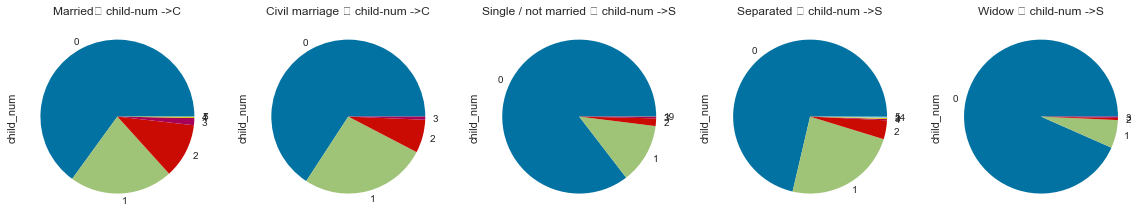

In [398]:
#그래프
plt.figure(figsize=(20, 6))
plt.subplot(151)
plt.title('Married별 child-num ->C')
train1[train1['family_type']=='Married']['child_num'].value_counts(normalize=True).plot(kind='pie')
plt.subplot(152)
plt.title('Civil marriage 별 child-num ->C')
train1[train1['family_type']=='Civil marriage']['child_num'].value_counts(normalize=True).plot(kind='pie')
plt.subplot(153)
plt.title('Single / not married 별 child-num ->S')
train1[train1['family_type']=='Single / not married']['child_num'].value_counts(normalize=True).plot(kind='pie')
plt.subplot(154)
plt.title('Separated 별 child-num ->S')
train1[train1['family_type']=='Separated']['child_num'].value_counts(normalize=True).plot(kind='pie')
plt.subplot(155)
plt.title('Widow 별 child-num ->S')
train1[train1['family_type']=='Widow']['child_num'].value_counts(normalize=True).plot(kind='pie')

In [413]:
#학생 7명 중 4명의 occyp_type상태가 core staff.
print(train['income_type'].value_counts())
train1[(train1['income_type']=='Student') & (train1['occyp_type']=='Core staff')]

Working                 13645
Commercial associate     6202
Pensioner                4449
State servant            2154
Student                     7
Name: income_type, dtype: int64


,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
2990,2990,F,N,Y,0,171000.00,Student,Higher education,Married,House / apartment,-18756,-3904,1,0,0,1,Core staff,2.00,-60.00,2.00
3602,3602,F,N,Y,0,171000.00,Student,Higher education,Married,House / apartment,-18756,-3904,1,0,0,1,Core staff,2.00,-39.00,1.00
8936,8936,F,N,Y,0,171000.00,Student,Higher education,Married,House / apartment,-18756,-3904,1,0,0,1,Core staff,2.00,-39.00,1.00
21681,21681,F,N,Y,0,171000.00,Student,Higher education,Married,House / apartment,-18756,-3904,1,0,0,1,Core staff,2.00,-35.00,1.00


In [414]:
#Student 전부 working으로 편입 -> 편입됨 확인
train['income_type'] = train['income_type'].replace('Student', 'Working')
print(train['income_type'].value_counts())
test['income_type'] = test['income_type'].replace('Student', 'Working')

Working                 13652
Commercial associate     6202
Pensioner                4449
State servant            2154
Name: income_type, dtype: int64


In [422]:
#family_size single, couple, fam, bigfam으로 구분
print(train['family_size'].value_counts())
train['family_size'] = train['family_size'].replace(1, 'single')
train['family_size'] = train['family_size'].replace(2, 'couple')
train['family_size'] = train['family_size'].replace([3,4], 'family')
train['family_size'] = train['family_size'].replace([5,6], 'big family')



2.00    14121
1.00     5109
3.00     4632
4.00     2260
5.00      291
6.00       44
Name: family_size, dtype: int64


In [433]:
#------------------------------------------------------------------------
test['family_size'] = test['family_size'].replace(1, 'single')
test['family_size'] = test['family_size'].replace(2, 'couple')
test['family_size'] = test['family_size'].replace([3,4], 'family')
test['family_size'] = test['family_size'].replace([5,6], 'big family')

In [642]:
train.head(1)

,gender,car,reality,income_type,edu_type,family_type,house_type,occyp_type,family_size,credit,ID,scal_begin_month,scal_age_total,scal_work_total,scal_contact_num,scal_Nth_card,scal_income_total,scal_income_mean,scal_age_income,scal_work_year_income
0,F,N,N,Pensioner,Higher education,couple,House / apartment,A,couple,0.00,0.00,0.60,0.79,0.00,0.33,0.06,0.05,0.05,0.02,0.00


In [643]:
test['house_type'].value_counts()

House / apartment      8895
With parents            519
Municipal apartment     310
Rented apartment        146
Office apartment         72
Co-op apartment          58
Name: house_type, dtype: int64

In [ ]:
def birth_catagory(value):
    ep = ''
    if value <= 30: ep = 'A'
    elif value <= 40: ep = 'B'
    elif value <= 50: ep = 'C'
    elif value <= 60: ep = 'D'
    elif value < 70: ep = 'E'
       
    return ep

In [652]:
train.head(1)

,gender,car,reality,income_type,edu_type,family_type,house_type,occyp_type,family_size,credit,ID,scal_begin_month,scal_age_total,scal_work_total,scal_contact_num,scal_Nth_card,scal_income_total,scal_income_mean,scal_age_income,scal_work_year_income
0,F,N,N,Pensioner,Higher education,couple,House / apartment,A,couple,0.00,0.00,0.60,0.79,0.00,0.33,0.06,0.05,0.05,0.02,0.00


In [649]:
train1.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit'],
      dtype='object')

In [425]:
train['edu_type'].value_counts()

Secondary / secondary special    17995
Higher education                  7162
Incomplete higher                 1020
Lower secondary                    257
Academic degree                     23
Name: edu_type, dtype: int64

In [442]:
len(train.columns)

20

In [441]:
len(test.columns)

19

In [434]:
#변수 drop
test.drop(columns=['DAYS_BIRTH_MOD','age_year','DAYS_BIRTH_MOD','age_year','age_month','DAYS_EMPLOYED_MOD', 'work_year', 'work_month'], inplace=True)
train.drop(columns=['DAYS_BIRTH_MOD','age_year','DAYS_BIRTH_MOD','age_year','age_month','DAYS_EMPLOYED_MOD', 'work_year', 'work_month'], inplace=True)

In [ ]:
#train.to_csv('train-1차 전처리.csv')
#test.to_csv('test-1차 전처리.csv')

In [605]:
#train_new = pd.read_csv(r'C:\Users\user\Desktop\code\[유비온]신용카드 사용자 연제 예측\SH\train-1차 전처리.csv')
#test_new = pd.read_csv(r'C:\Users\user\Desktop\code\[유비온]신용카드 사용자 연제 예측\SH\test-1차 전처리.csv')
train = pd.read_csv(r'C:\Users\user\Desktop\code\[유비온]신용카드 사용자 연제 예측\SH\train-1차 전처리.csv')
test = pd.read_csv(r'C:\Users\user\Desktop\code\[유비온]신용카드 사용자 연제 예측\SH\test-1차 전처리.csv')

# minmax scaling

In [587]:
train.head(3)

,gender,car,reality,income_type,edu_type,family_type,house_type,occyp_type,family_size,begin_month,credit,age_total,work_total,ID,Nth_card,contact_num,scal_income_total,scal_income_mean,scal_age_income,scal_work_year_income
0,F,N,N,Pensioner,Higher education,couple,House / apartment,A,couple,-24.00,0.00,57.42,0.00,0.00,3,2,0.05,0.05,0.02,0.00
1,F,N,N,Pensioner,Higher education,couple,House / apartment,A,couple,-28.00,0.00,57.08,0.00,0.00,2,2,0.05,0.05,0.02,0.00
2,F,N,N,Pensioner,Higher education,couple,House / apartment,A,couple,-30.00,2.00,57.00,0.00,0.00,1,2,0.05,0.05,0.02,0.00


In [607]:
numeric_train=train[['begin_month', 'age_total','work_total','contact_num','Nth_card']]
numeric_test=test[['begin_month', 'age_total','work_total','contact_num','Nth_card']]
numeric_train

,begin_month,age_total,work_total,contact_num,Nth_card
0,-24.00,57.42,0.00,2,3
1,-28.00,57.08,0.00,2,2
2,-30.00,57.00,0.00,2,1
3,-17.00,65.83,0.00,1,2
4,-39.00,64.00,0.00,1,1
...,...,...,...,...,...
26452,-24.00,36.75,0.00,1,1
26453,-19.00,29.58,5.92,1,4
26454,-21.00,29.42,5.75,1,3
26455,-46.00,27.33,3.67,1,2


In [609]:
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler = MinMaxScaler()
MinMaxScaler.fit(numeric_train)
train[['scal_begin_month', 'scal_age_total', 'scal_work_total', 'scal_contact_num','scal_Nth_card']] = MinMaxScaler.transform(numeric_train)
train.drop(columns=['begin_month', 'age_total','work_total','contact_num','Nth_card'], inplace=True)

In [610]:
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler = MinMaxScaler()
MinMaxScaler.fit(numeric_test)
test[['scal_begin_month', 'scal_age_total', 'scal_work_total', 'scal_contact_num','scal_Nth_card']] = MinMaxScaler.transform(numeric_test)
test.drop(columns=['begin_month', 'age_total','work_total','contact_num','Nth_card'], inplace=True)

In [611]:
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler = MinMaxScaler()
MinMaxScaler.fit(income_train)
train[['scal_income_total', 'scal_income_mean', 'scal_age_income', 'scal_work_year_income']] = MinMaxScaler.transform(income_train)
train.drop(columns=['income_total', 'income_mean', 'age_income','work_year_income'], inplace=True)

In [612]:
from sklearn.preprocessing import MinMaxScaler
MinMaxScaler = MinMaxScaler()
MinMaxScaler.fit(income_test)
test[['scal_income_total', 'scal_income_mean', 'scal_age_income','scal_work_year_income']] = MinMaxScaler.transform(income_test)
test.drop(columns=['income_total', 'income_mean', 'age_income','work_year_income'], inplace=True)


In [ ]:
#numerical_feats.remove('income_total')
#numerical_feats.remove('credit')
#scaler = StandardScaler()
#train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
#test[numerical_feats] = scaler.transform(test[numerical_feats])

In [203]:
# numeric_list = ['income_mean','income_total', 'work_total', 'age_total', 'begin_month']
# len(train.columns.values)
# # != numeric_list
# object_list = []
# for i in len(train.columns.values):
#     if (train.columns.values[i] != numeric_list) == False
#     object_list.append(i)
    
    
    
# #train.columns.values[0] != numeric_list
# #if train.columns
# #numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()

SyntaxError: invalid syntax (Temp/ipykernel_19496/3234435170.py, line 6)

In [489]:
train.head(1)
train.columns

Index(['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type',
       'house_type', 'occyp_type', 'family_size', 'begin_month', 'credit',
       'age_total', 'work_total', 'ID', 'Nth_card', 'contact_num',
       'scal_income_total', 'scal_income_mean', 'scal_age_income',
       'scaler_work_year_income'],
      dtype='object')

## 인코딩

In [499]:
numerical_feats = ['work_total', 'age_total', 'begin_month',
                   'contact_num', 'Nth_card', 'scal_income_total', 'scal_income_mean', 'scal_age_income', 'scaler_work_year_income']
categorical_feats = ['gender', 'car', 'reality', 'income_type', 'edu_type','family_type', 'house_type', 'occyp_type', 'ID','family_size']

In [540]:
from category_encoders.ordinal import OrdinalEncoder
encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
encoder = OrdinalEncoder(categorical_feats)
test[categorical_feats] = encoder.fit_transform(test[categorical_feats])

In [541]:
test

,gender,car,reality,income_type,edu_type,family_type,house_type,occyp_type,family_size,begin_month,age_total,work_total,ID,Nth_card,contact_num,scal_income_total,scal_income_mean,scal_age_income,scaler_work_year_income
0,1,1,1,1,1,1,1,1,1,-3.00,59.17,0.00,0.00,3,2,0.05,0.05,0.02,0.00
1,1,1,1,1,1,1,1,1,1,-46.00,55.67,0.00,0.00,2,2,0.05,0.05,0.02,0.00
2,1,1,1,1,1,1,1,1,1,-53.00,55.08,0.00,0.00,1,2,0.05,0.05,0.02,0.00
3,1,1,1,1,1,2,1,1,2,-28.00,64.92,0.00,1.00,1,1,0.05,0.11,0.02,0.00
4,1,1,1,1,2,1,1,1,1,-11.00,54.17,0.00,2.00,2,1,0.05,0.05,0.02,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,2,2,2,2,1,1,2,4,-7.00,37.00,5.00,5583.00,1,1,0.03,0.00,0.02,0.00
9996,2,2,2,2,2,1,4,5,1,-2.00,31.00,7.25,5584.00,4,1,0.11,0.10,0.10,0.00
9997,2,2,2,2,2,1,4,5,1,-26.00,29.00,5.33,5584.00,3,1,0.11,0.10,0.10,0.00
9998,2,2,2,2,2,1,4,5,1,-37.00,28.08,4.42,5584.00,2,1,0.11,0.10,0.11,0.00


In [570]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 26457 non-null  object 
 1   car                    26457 non-null  object 
 2   reality                26457 non-null  object 
 3   income_type            26457 non-null  object 
 4   edu_type               26457 non-null  object 
 5   family_type            26457 non-null  object 
 6   house_type             26457 non-null  object 
 7   occyp_type             26457 non-null  object 
 8   family_size            26457 non-null  object 
 9   begin_month            26457 non-null  float64
 10  credit                 26457 non-null  float64
 11  age_total              26457 non-null  float64
 12  work_total             26457 non-null  float64
 13  ID                     26457 non-null  float64
 14  Nth_card               26457 non-null  int64  
 15  co

In [572]:
train.to_csv('train_final.csv')
test.to_csv('test_final.csv')
train_final = pd.read_csv(r'C:\Users\user\Desktop\code\[유비온]신용카드 사용자 연제 예측\SH\train_final.csv')
test_final = pd.read_csv(r'C:\Users\user\Desktop\code\[유비온]신용카드 사용자 연제 예측\SH\test_final.csv')

In [613]:
train

,Unnamed: 0,gender,car,reality,income_type,edu_type,family_type,house_type,occyp_type,family_size,...,ID,scal_begin_month,scal_age_total,scal_work_total,scal_contact_num,scal_Nth_card,scal_income_total,scal_income_mean,scal_age_income,scal_work_year_income
0,0,F,N,N,Pensioner,Higher education,couple,House / apartment,A,couple,...,0.00,0.60,0.79,0.00,0.33,0.06,0.05,0.05,0.02,0.00
1,1,F,N,N,Pensioner,Higher education,couple,House / apartment,A,couple,...,0.00,0.53,0.78,0.00,0.33,0.03,0.05,0.05,0.02,0.00
2,2,F,N,N,Pensioner,Higher education,couple,House / apartment,A,couple,...,0.00,0.50,0.78,0.00,0.33,0.00,0.05,0.05,0.02,0.00
3,3,F,N,N,Pensioner,Higher education,single,House / apartment,A,single,...,1.00,0.72,0.96,0.00,0.00,0.03,0.05,0.11,0.02,0.00
4,4,F,N,N,Pensioner,Higher education,single,House / apartment,A,single,...,1.00,0.35,0.92,0.00,0.00,0.00,0.05,0.11,0.02,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,M,Y,Y,Working,Secondary / secondary special,couple,House / apartment,E,big family,...,8757.00,0.60,0.36,0.00,0.00,0.00,0.17,0.05,0.11,0.00
26453,26453,M,Y,Y,Working,Secondary / secondary special,couple,Co-op apartment,C,couple,...,8758.00,0.68,0.22,0.14,0.00,0.09,0.11,0.10,0.10,0.01
26454,26454,M,Y,Y,Working,Secondary / secondary special,couple,Co-op apartment,C,couple,...,8758.00,0.65,0.21,0.14,0.00,0.06,0.11,0.10,0.10,0.01
26455,26455,M,Y,Y,Working,Secondary / secondary special,couple,Co-op apartment,C,couple,...,8758.00,0.23,0.17,0.09,0.00,0.03,0.11,0.10,0.11,0.01


In [625]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

In [626]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical

In [627]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test

In [631]:

train_x = pd.get_dummies(train_x, drop_first=True)
test_x = pd.get_dummies(test_x, drop_first=True)

In [629]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

'''print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)'''

# 모델 학습
cat_clf=CatBoostClassifier()
cat_clf.fit(X_train, y_train)
y_pred=cat_clf.predict_proba(X_val)

# 평가
print("훈련 세트 정확도: {:.3f}".format(cat_clf.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(cat_clf.score(X_val, y_val)))

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

Learning rate set to 0.092151
0:	learn: 1.0471644	total: 18.8ms	remaining: 18.8s
1:	learn: 1.0060585	total: 26.7ms	remaining: 13.3s
2:	learn: 0.9733461	total: 34.2ms	remaining: 11.4s
3:	learn: 0.9463649	total: 39.9ms	remaining: 9.93s
4:	learn: 0.9243055	total: 46.5ms	remaining: 9.26s
5:	learn: 0.9056267	total: 52.6ms	remaining: 8.72s
6:	learn: 0.8901915	total: 58.2ms	remaining: 8.26s
7:	learn: 0.8773267	total: 63.6ms	remaining: 7.88s
8:	learn: 0.8670114	total: 68.7ms	remaining: 7.56s
9:	learn: 0.8580449	total: 75.1ms	remaining: 7.43s
10:	learn: 0.8501296	total: 81.6ms	remaining: 7.33s
11:	learn: 0.8435922	total: 87.7ms	remaining: 7.22s
12:	learn: 0.8380028	total: 94.8ms	remaining: 7.2s
13:	learn: 0.8331027	total: 101ms	remaining: 7.11s
14:	learn: 0.8286786	total: 108ms	remaining: 7.06s
15:	learn: 0.8250001	total: 114ms	remaining: 6.99s
16:	learn: 0.8217465	total: 120ms	remaining: 6.96s
17:	learn: 0.8189198	total: 127ms	remaining: 6.93s
18:	learn: 0.8166183	total: 133ms	remaining: 6.85s

<AxesSubplot:>

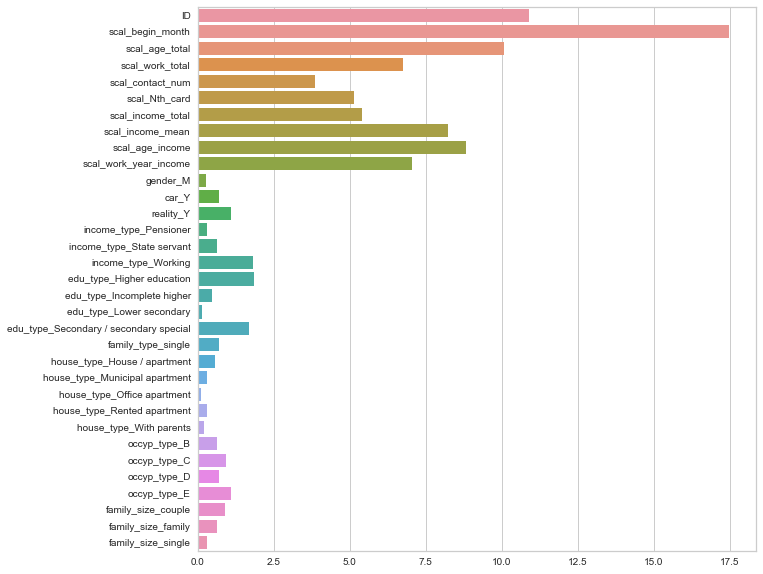

In [630]:
# 특성 중요도 시각화
import seaborn as sns
plt.figure(figsize=(10,10))
feature_names = list(train_x.columns)
sns.barplot(cat_clf.feature_importances_, y=feature_names)

In [633]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(cat_clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        cat_clf.fit(X_train, y_train)
        
        predictions=cat_clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=cat_clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(cat_clf)

Learning rate set to 0.092455
0:	learn: 1.0467023	total: 20.4ms	remaining: 20.3s
1:	learn: 1.0051910	total: 28ms	remaining: 14s
2:	learn: 0.9722668	total: 35.2ms	remaining: 11.7s
3:	learn: 0.9451489	total: 42ms	remaining: 10.5s
4:	learn: 0.9231160	total: 48.7ms	remaining: 9.69s
5:	learn: 0.9042822	total: 55.3ms	remaining: 9.17s
6:	learn: 0.8887131	total: 62ms	remaining: 8.8s
7:	learn: 0.8755339	total: 68.9ms	remaining: 8.54s
8:	learn: 0.8645766	total: 75.8ms	remaining: 8.35s
9:	learn: 0.8556803	total: 82.4ms	remaining: 8.16s
10:	learn: 0.8479912	total: 89.1ms	remaining: 8.01s
11:	learn: 0.8415235	total: 95.7ms	remaining: 7.88s
12:	learn: 0.8361870	total: 102ms	remaining: 7.77s
13:	learn: 0.8314794	total: 109ms	remaining: 7.69s
14:	learn: 0.8270995	total: 116ms	remaining: 7.59s
15:	learn: 0.8237012	total: 122ms	remaining: 7.52s
16:	learn: 0.8205161	total: 128ms	remaining: 7.43s
17:	learn: 0.8177237	total: 135ms	remaining: 7.36s
18:	learn: 0.8153384	total: 142ms	remaining: 7.36s
19:	lear

In [634]:
my_submission

array([[0.20317468, 0.77591666, 0.02090866],
       [0.11256478, 0.21387384, 0.67356139],
       [0.11829312, 0.16201627, 0.71969061],
       ...,
       [0.18253458, 0.14611949, 0.67134592],
       [0.15992864, 0.13410771, 0.70596365],
       [0.16090591, 0.10561031, 0.73348378]])

In [635]:
submission.loc[:,1:]=my_submission

In [636]:
submission

,index,0,1,2
0,26457,0.20,0.78,0.02
1,26458,0.11,0.21,0.67
2,26459,0.12,0.16,0.72
3,26460,0.12,0.14,0.74
4,26461,0.04,0.11,0.85
...,...,...,...,...
9995,36452,0.12,0.15,0.73
9996,36453,0.24,0.74,0.02
9997,36454,0.18,0.15,0.67
9998,36455,0.16,0.13,0.71


In [637]:
submission.to_csv('1104cat2_submission.csv', index=False)

# StandardScaler 

In [ ]:
#numerical_feats.remove('income_total')
#numerical_feats.remove('credit')
#scaler = StandardScaler()
#train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
#test[numerical_feats] = scaler.transform(test[numerical_feats])